# kWh Analytics

See below for code samples and analysis.

## Conclusions

1. We see a slight trend, with Vintage A showing mean Performance Ratio of 1.05, Vintage B at 1.04, and Vintage C at 1.02
1. The three vintages rank similarly in frequency of very low performing systems, with C showing very low performance twice as often as A and B.
1. There is a wide variance on the performance here. If we had other metrics as mentioned above, we could run regressions to explain some of the noise, to give more confidence to our findings. 

## Other considerations on the current data set

1. Look at some temporal smoothing across months for a clearer signal.
1. Investigate consistently low performing systems, vs. intermittent low months. 
1. What is the goal of the analysis, beyond "panel quality changes year-to-year"? Are we trying to identify the best panel to use for average performance? The lowest risk panel of low performance? These have implications on the financial decisions based on the data set.

## Helpful additional information for further investigation

1. Other meta-data about the systems: tilt, azimuth, lat/long, system size, inverter brand, roof surface, etc.
1. Information about maintenance activity. Were defective panels replaced or repaired at these low-performing systems?
1. Information on low-performing system-months. Were these due to panel defect, or other?
1. Information about the racking structures and wiring.
1. Information on any external factors - grid outages, etc. 
1. Definition of "expected kWh". Is this a contractual estimate based on PVWatts? Or expected based on actual measured irradiance? How confident are we in these estimates?
1. More data. We have a few thousand samples per panel vintage, but some low-frequency events, such as 0 kWh production months, are rare on a data set this size. These events could have a great impact on the performance guarantee of a system, and need closer attention

###### Joe Bryan. 2016-11-07.

----------

## 1. Read raw data into DataFrame for analysis

In [183]:
%matplotlib inline
import gzip
import math
import scipy.stats
import pandas as pd
import numpy as np
from matplotlib import pyplot
from matplotlib import mlab

filename = 'data/datasci_takehome.csv.gz'

df = pd.read_table(filename, compression='gzip', sep=',')

vintages = list('ABC')

## 2. Overview
### Plot some basic summary metrics to get a sense of the data set
#### Test 1: Vintages will show better or worse performance on a simple cross-system average. 
#### Test 2: Some vintage might show seasonal performance differences - due to sun angle, temperature coefficient, etc.

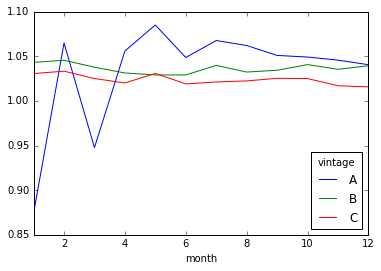

In [184]:
df['pr'] = df['correctedkwh'] / df['expectedkwh']  # element-wise PR
vintage_month = df.groupby(['vintage', 'month'])
vintage_month_pr = vintage_month.sum()['correctedkwh'] / vintage_month.sum()['expectedkwh']
vintage_month_pr.unstack(level=0).plot()

#### Test 3: Check the data completeness of our data set
Turns out we have very little data on vintage A, especially in the winter and spring months. This may not be enough to draw much of a conclusion about. 

Or, perhaps, the system operator replaced or exchanged panels after this.

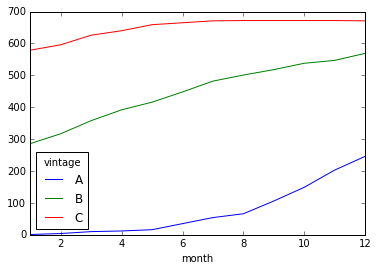

In [185]:
vintage_month.size().unstack(level=0).plot()

## 3. Remove outliers

We'll leave in low-Performance outliers for now - these likely represent true system failures.
We'll remove high-performance outliers - these likely represent measurement or expectation errors.

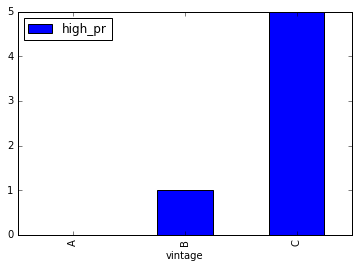

In [186]:
# see how common high outliers are

df['high_pr'] = df['pr'] > 2
df.groupby(['vintage']).sum()[['high_pr']].plot(kind='bar')

In [187]:
# Remove the high outliers
df.drop(df['high_pr'] == False, inplace=True)

#### Test 4: Check data consistency

We expect to see high variability in vintage A especially in the winter-spring months where there is little data.
We also expect to see higher variability in the winter months where weather is more variable. 

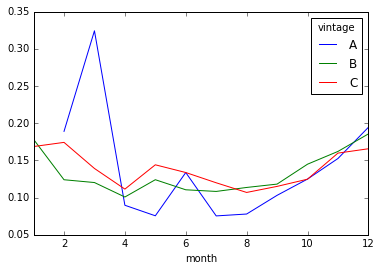

In [188]:
vintage_month.std()['pr'].unstack(level=0).plot()

#### Test 5: Weight higher production systems

i.e. weight by panel count

       avg       std
A  1.04979  0.133006
B  1.03529  0.128777
C  1.02346  0.137767


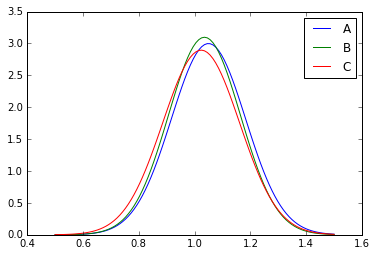

In [189]:
def weighted_avg_and_std(values, weights):
    """Via: http://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-numpy"""
    average = np.average(values, weights=weights)
    variance = np.average((values - average)**2, weights=weights)
    return (average, math.sqrt(variance))

metrics=['avg', 'std']
df_weighted = pd.DataFrame(index=vintages, columns=metrics)
x = np.linspace(0.5, 1.5, 100)

for vintage in vintages:
    values = df['pr'][df['vintage'] == vintage]
    weights = df['expectedkwh'][df['vintage'] == vintage]
    avg, std = weighted_avg_and_std(values, weights)
    df_weighted.loc[vintage, 'avg'] = avg
    df_weighted.loc[vintage, 'std'] = std
    pyplot.plot(x, mlab.normpdf(x, avg, std), label=vintage)
    
print(df_weighted)
pyplot.legend(loc='upper right')
pyplot.show()

#### Test 6: Check for duplicates

In [190]:
df.groupby(['correctedkwh']).size().max()  # returns 1, no apparent duplicates

1

## 4. Characterize distribution of system-month performance ratios
#### Test 7: Observe distribution of system-month performance ratio measurements

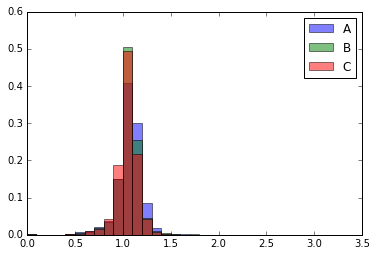

In [191]:
bins = np.arange(0, df['pr'].max(), 0.1)

for vintage in vintages:
    pr = df['pr'][df['vintage'] == vintage]
    pyplot.hist(pr, bins, alpha=0.5, label=vintage, weights=(pr/len(pr)))
    
pyplot.legend(loc='upper right')
pyplot.show()

#### Test 8: How frequently do low performance months occur

           low_pr  very_low_pr
vintage                       
A        0.008889     0.001111
B        0.008749     0.000745
C        0.009750     0.002053


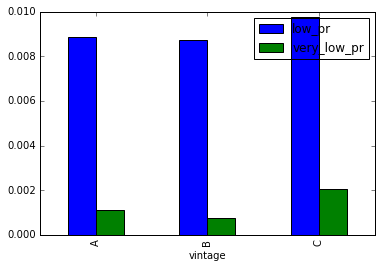

In [192]:
df['low_pr'] = df['pr'] < 0.5
df['very_low_pr'] = df['pr'] < 0.1

df_low = df.groupby(['vintage']).mean()[['low_pr', 'very_low_pr']]
print(df_low)
df_low.plot(kind='bar')